In [1]:
# import packages

import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import h5py
import requests as rq
import random
random.seed(2022)

In [2]:
# import sodapop

! git clone https://github.com/landryp/sodapop.git # only need to run this once
import sys
import os
sys.path.insert(0,os.getcwd()+'/sodapop')
import sodapop.priors as prior
import sodapop.populations as pop

Cloning into 'sodapop'...
remote: Enumerating objects: 763, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 763 (delta 55), reused 49 (delta 34), pack-reused 683
Receiving objects: 100% (763/763), 2.76 MiB | 19.52 MiB/s, done.
Resolving deltas: 100% (417/417), done.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


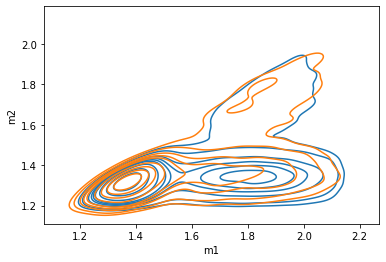

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


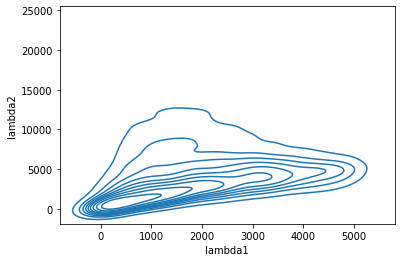

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


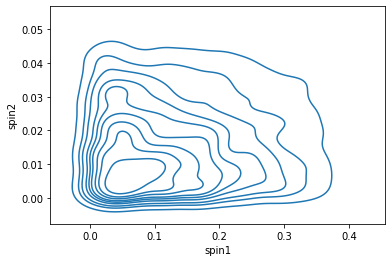

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


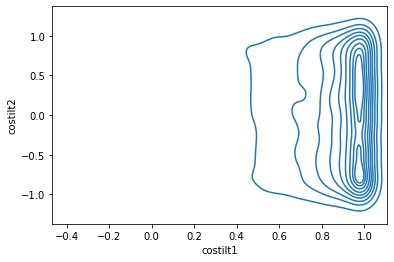

In [3]:
# draw samples from the new prior distribution, so that we can plot it

num_grid = int(1e5)
num_prior = int(1e4)
prior_data = pd.DataFrame({'m1': []})

mAs = np.random.uniform(1.2,2.3,10*num_grid)
mBs = np.random.uniform(1.2,2.3,10*num_grid)
M1s = np.array([max(A,B) for A,B in zip(mAs,mBs)])
M2s = np.array([min(A,B) for A,B in zip(mAs,mBs)])

m_pop = [1.34, 0.07, 1.80, 0.21, 0.65, 0.9, 2.12] # maximum a posteriori population model from arXiv:1709.07889
m_wts = pop.get_pop_prior('bimodcut_m1m2')(M1s,M2s,m_pop)

idxs = np.random.choice(range(len(M1s)),num_grid,True,m_wts/m_wts.sum())
qs = M2s[idxs]/M1s[idxs]
m1s = M1s[idxs]
m2s = M2s[idxs]

sns.kdeplot(m1s,m2s)

L1s = np.random.uniform(0.,5000.,num_grid)
L2s = np.random.uniform(0.,5000.*(2.3/1.2)**3,num_grid)

L_wts = np.array([(pop.get_pop_prior('peak_Lambda')(L1*q**-3,(q**3*L2,0.5*(L1*q**-3+q**3*L2)*0.5/1.645))*q**3*pop.get_pop_prior('unif_mass')(q**3*L2,(0.,5000.)))[0] for L1,L2,q in zip(L1s,L2s,qs)])

idxs = np.random.choice(range(len(L1s)),num_prior,True,L_wts/L_wts.sum())
prior_data['lambda1'] = L1s[idxs]
prior_data['lambda2'] = L2s[idxs]
prior_data['m1'] = m1s[idxs]
prior_data['m2'] = m2s[idxs]
prior_data['q'] = qs[idxs]

sns.kdeplot(prior_data['m1'],prior_data['m2'])
plt.show()

sns.kdeplot(prior_data['lambda1'],prior_data['lambda2'])
plt.show()

chi1s = np.random.uniform(0.,0.4,num_grid)
chi2s = np.random.uniform(0.,0.05,num_grid)
cost1s = np.random.uniform(-1.,1.,num_grid)
cost2s = np.random.uniform(-1.,1.,num_grid)

spin_pop = [-1.,0.,0.4,-1.,0.,0.05]
spin_wts = pop.get_pop_prior('power_chi1_power_chi2')(chi1s,chi2s,spin_pop)*pop.get_pop_prior('peak_mass')(np.arccos(cost1s),(0.,np.pi/6.))/np.sin(np.arccos(cost1s))

idxs = np.random.choice(range(len(chi1s)),num_prior,True,spin_wts/spin_wts.sum())
prior_data['spin1'] = chi1s[idxs]
prior_data['spin2'] = chi2s[idxs]
prior_data['costilt1'] = cost1s[idxs]
prior_data['costilt2'] = cost2s[idxs]

sns.kdeplot(prior_data['spin1'],prior_data['spin2'])
plt.show()

sns.kdeplot(prior_data['costilt1'],prior_data['costilt2'])
plt.show()

In [4]:
# define transformed observables

def mchirp_from_mass1_mass2(mass1, mass2):
    """Returns the chirp mass from mass1 and mass2."""
    return eta_from_mass1_mass2(mass1, mass2)**(3./5) * (mass1+mass2)

def eta_from_mass1_mass2(mass1, mass2):
    """Returns the symmetric mass ratio from mass1 and mass2."""
    return mass1*mass2 / (mass1+mass2)**2.

def chi_eff(mass1, mass2, spin1z, spin2z): 
    """Returns the effective spin from mass1, mass2, spin1z, and spin2z."""
    return (spin1z * mass1 + spin2z * mass2) / (mass1 + mass2)

def lambdatilde(lambda1,lambda2,m1,m2): 
    mtotal = m1+m2
    m1fac=m1+12*m2
    m2fac=m2+12*m1
    return 16./13*(m1fac*m1**(4)*lambda1+m2fac*m2**(4)*lambda2)/mtotal**(5)

prior_data['mchirp'] = prior_data.apply(lambda row : mchirp_from_mass1_mass2(row['m1'], row['m2']) , axis = 1)
prior_data['q']= prior_data.apply(lambda row : row['m2']/ row['m1'] , axis = 1)
prior_data['chi_eff']= prior_data.apply(lambda row : chi_eff(
    row['m1'], row['m2'], row['spin1']*row['costilt1'],row['spin2']*row['costilt2']  ) , axis = 1)
prior_data['lambdatilde'] = prior_data.apply(lambda row : lambdatilde(
    row['lambda1'], row['lambda2'], row['m1'], row['m2'] ) , axis = 1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


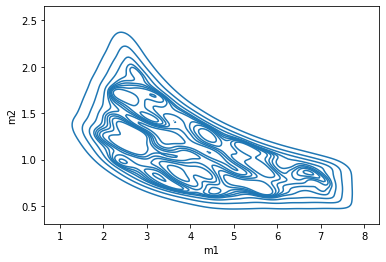

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


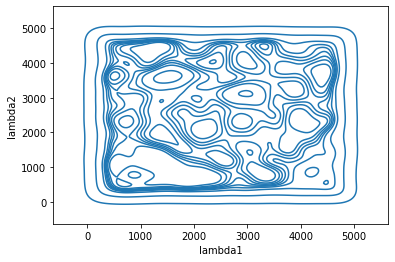

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


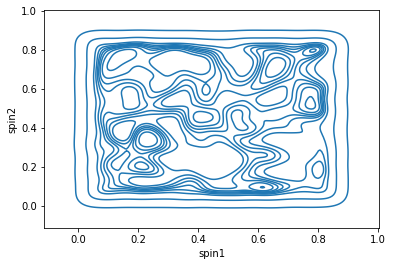

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


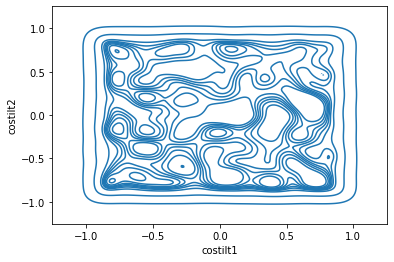

In [5]:
# draw samples from the old prior distribution, so that we can plot it

num_grid = int(1e6)
num_prior = int(1e5)
prior_data0 = pd.DataFrame({'m1': []})

mAs = np.random.uniform(0.5,7.7,10*num_grid)
mBs = np.random.uniform(0.5,7.7,10*num_grid)
M1s = np.array([max(A,B) for A,B in zip(mAs,mBs)])
M2s = np.array([min(A,B) for A,B in zip(mAs,mBs)])
Mcs = mchirp_from_mass1_mass2(M1s, M2s)

Mc_bnds = (1.184,2.168)
m_wts = pop.get_pop_prior('unif_mass')(Mcs,Mc_bnds)

idxs = np.random.choice(range(len(M1s)),num_prior,True,m_wts/m_wts.sum())
prior_data0['q'] = M2s[idxs]/M1s[idxs]
m1s = M1s[idxs]
m2s = M2s[idxs]

prior_data0['m1'] = m1s/(1+0.0099) # convert detector frame masses to source frame in gw170817 samples -- note that the paper actually fixed z = 0.0099
prior_data0['m2'] = m2s/(1+0.0099)

sns.kdeplot(prior_data0['m1'],prior_data0['m2'])
plt.show()

prior_data0['lambda1'] = np.random.uniform(0.,5000.,num_prior)
prior_data0['lambda2'] = np.random.uniform(0.,5000.,num_prior)

sns.kdeplot(prior_data0['lambda1'],prior_data0['lambda2'])
plt.show()

prior_data0['spin1'] = np.random.uniform(0.,0.89,num_prior)
prior_data0['spin2'] = np.random.uniform(0.,0.89,num_prior)
prior_data0['costilt1'] = np.random.uniform(-1.,1.,num_prior)
prior_data0['costilt2'] = np.random.uniform(-1.,1.,num_prior)

sns.kdeplot(prior_data0['spin1'],prior_data0['spin2'])
plt.show()

sns.kdeplot(prior_data0['costilt1'],prior_data0['costilt2'])
plt.show()

In [6]:
prior_data0['mchirp'] = prior_data0.apply(lambda row : mchirp_from_mass1_mass2(row['m1'], row['m2']) , axis = 1)
prior_data0['q']= prior_data0.apply(lambda row : row['m2']/ row['m1'] , axis = 1)
prior_data0['chi_eff']= prior_data0.apply(lambda row : chi_eff(
    row['m1'], row['m2'], row['spin1']*row['costilt1'],row['spin2']*row['costilt2']  ) , axis = 1)
prior_data0['lambdatilde'] = prior_data0.apply(lambda row : lambdatilde(
    row['lambda1'], row['lambda2'], row['m1'], row['m2'] ) , axis = 1)

In [7]:
prior_data['prior'] = 'Galactic (prior)'
prior_data0['prior'] = 'LVC (prior)'

df = pd.concat([prior_data, prior_data0]).reset_index()

In [8]:
# reflect kde

reflected_df = prior_data.truncate(after=1).copy()
reflected_idx = 0

for idx in list(df.index.values):

	q = df.at[idx,'q']
	Lt = df.at[idx,'lambdatilde']
	
	if q > 0.95:
		reflected_df.loc[reflected_idx] = df.loc[idx]
		reflected_df.loc[reflected_idx].at['q'] = 1. + np.abs(1.-q)
		reflected_idx = reflected_idx + 1
		
	if Lt < 5.:
		reflected_df.loc[reflected_idx] = df.loc[idx]
		reflected_df.loc[reflected_idx].at['lambdatilde'] = -np.abs(Lt)
		reflected_idx = reflected_idx + 1

reflected_df=reflected_df.drop(reflected_df.index[0])
df = pd.concat([df.reset_index(drop=True),reflected_df.reset_index(drop=True)],ignore_index=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_values(loc, value)


In [62]:
# specify some global plot settings

sns.set_palette([sns.color_palette("Paired")[1],sns.color_palette("Paired")[3],'k',sns.color_palette("Paired")[8]])
palette = {"Galactic (prior)": sns.color_palette()[0], 'LVC (prior)': sns.color_palette()[1], 'Galactic': sns.color_palette()[2], 'LVC': sns.color_palette()[1]}

replacements = {'m1': r'$m_1 \,[M_\odot]$', 'm2': r'$m_2 \,[M_\odot]$', 'spin1': r'$\chi_1$', 'spin2': r'$\chi_2$', 'lambda1': r'$\Lambda_1$', 'lambda2': r'$\Lambda_2$', 'mchirp': r'$\mathcal{M} \,[M_\odot]$', 'q': r'$q$', 'chi_eff': r'$\chi_\mathrm{eff}$', 'lambdatilde': r'$\tilde{\Lambda}$'}
limits = {'m1': (0.5,3.), 'm2': (0.5,3.), 'spin1': (0.,1.), 'spin2': (0.,1.), 'lambda1': (0.,5000.), 'lambda2': (0.,5000.), 'mchirp': (0.5,2.5), 'q': (0.,1.), 'chi_eff': (-1.,1.), 'lambdatilde': (0.,10000.)}

handles = {}
for key in palette.keys():
  if key == 'LVC (prior)': handles[key] = (mpatches.Patch(facecolor=palette['LVC (prior)'], edgecolor=None, alpha=0.2, label=key), mlines.Line2D([], [], color=palette['LVC (prior)'], label=key))
  else: handles[key] = mlines.Line2D([], [], color=palette[key], label=key)

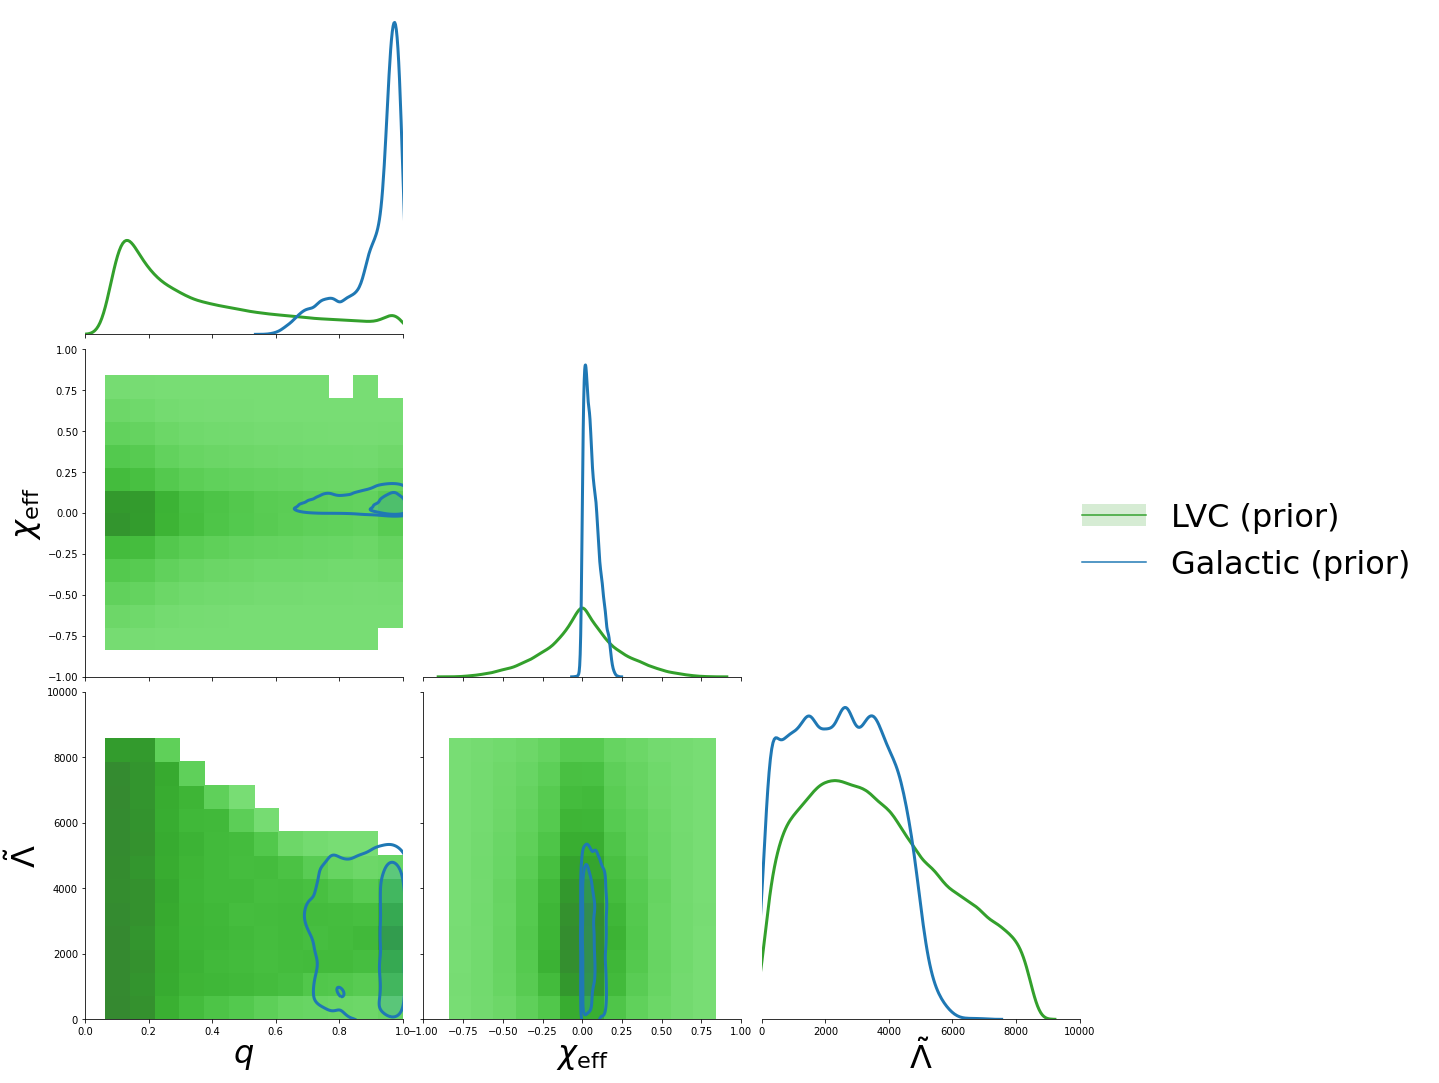

In [63]:
vars = ['q','chi_eff','lambdatilde']

fig = sns.PairGrid(df, vars=vars, corner=True, diag_sharey=False, height=5.)

fig.map_diag(sns.kdeplot, data=df, hue='prior', hue_order=['LVC (prior)'], palette=palette, fill=False, common_norm=False, linewidth=3)
fig.map_diag(sns.kdeplot, data=df, hue='prior', hue_order=['Galactic (prior)'], palette=palette, fill=False, common_norm=False, linewidth=3)
fig.map_lower(sns.histplot, data=df, hue='prior', hue_order=['LVC (prior)'], palette=palette, stat='density', bins=12)
fig.map_lower(sns.kdeplot, data=df, hue='prior', hue_order=['Galactic (prior)'], palette=palette, levels=[0.1,0.5], linewidths=3)
fig.map_lower(sns.kdeplot, data=df, hue='prior', hue_order=['Galactic (prior)'], palette=palette, fill=True, alpha=0.2, levels=[0.5,1.])

fig.add_legend(label_order=['LVC (prior)','Galactic (prior)'],legend_data=handles,fontsize=32)

for i in range(len(vars)):
    for j in range(i+1):
        xlabel = vars[j]
        ylabel = vars[i]
        if xlabel in replacements.keys():
            fig.axes[i][j].set_xlabel(replacements[xlabel],fontsize=32)
            fig.axes[i][j].set_xlim(*limits[xlabel])
        if ylabel in replacements.keys():
            fig.axes[i][j].set_ylabel(replacements[ylabel],fontsize=32)
            fig.axes[i][j].set_ylim(*limits[ylabel])

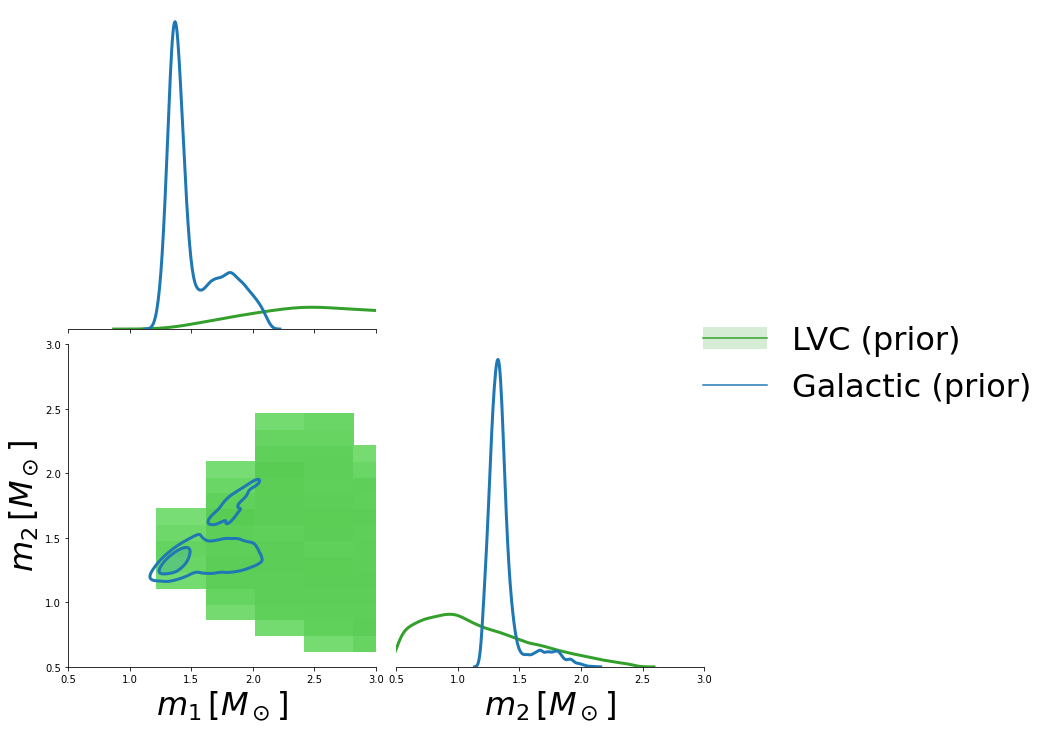

In [65]:
vars = ['m1','m2']

fig = sns.PairGrid(df, vars=vars, corner=True, diag_sharey=False, height=5.)

fig.map_diag(sns.kdeplot, data=df, hue='prior', hue_order=['LVC (prior)'], palette=palette, fill=False, common_norm=False, linewidth=3)
fig.map_diag(sns.kdeplot, data=df, hue='prior', hue_order=['Galactic (prior)'], palette=palette, fill=False, common_norm=False, linewidth=3)
fig.map_lower(sns.histplot, data=df, hue='prior', hue_order=['LVC (prior)'], palette=palette, stat='density', bins=16)
fig.map_lower(sns.kdeplot, data=df, hue='prior', hue_order=['Galactic (prior)'], palette=palette, levels=[0.1,0.5], linewidths=3)
fig.map_lower(sns.kdeplot, data=df, hue='prior', hue_order=['Galactic (prior)'], palette=palette, fill=True, alpha=0.2, levels=[0.5,1.])

fig.add_legend(label_order=['LVC (prior)','Galactic (prior)'],legend_data=handles,fontsize=32)

for i in range(len(vars)):
    for j in range(i+1):
        xlabel = vars[j]
        ylabel = vars[i]
        if xlabel in replacements.keys():
            fig.axes[i][j].set_xlabel(replacements[xlabel],fontsize=32)
            fig.axes[i][j].set_xlim(*limits[xlabel])
        if ylabel in replacements.keys():
            fig.axes[i][j].set_ylabel(replacements[ylabel],fontsize=32)
            fig.axes[i][j].set_ylim(*limits[ylabel])